In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [1]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/distan_lat41.296lon2.078p2R12Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Weather frequencies


M                 94.43%
-RA                1.96%
-DZ                0.72%
RA                 0.63%
BR                 0.53%
SHRA               0.18%
VCTS               0.14%
-SHRA              0.13%
TSRA               0.12%
VCSH               0.09%
TS                 0.08%
DZ                 0.07%
+RA                0.07%
+TSRA              0.07%
-TSRA              0.06%
-RA BR             0.05%
-RA VCTS           0.05%
BCFG               0.05%
+SHRA              0.04%
BR -RA             0.04%
BR BCFG            0.04%
-RA VCSH           0.03%
FG                 0.03%
VCFG               0.02%
BR -DZ             0.02%
TS -RA             0.02%
VCTS -RA           0.02%
-SHRA VCTS         0.02%
RA VCTS            0.02%
SHRA VCTS          0.01%
+SHRA VCTS         0.01%
-DZ BR             0.01%
RA BR              0.01%
BR RA              0.01%
-RA TS             0.01%
BR DZ              0.01%
TS VCSH            0.01%
BR VCFG            0.01%
VCSH -RA           0.01%
BCFG BR            0.01%


*****************************
Climatology RA or DZ


No RA/DZ    95%
RA/DZ        5%
Name: prec_l, dtype: object

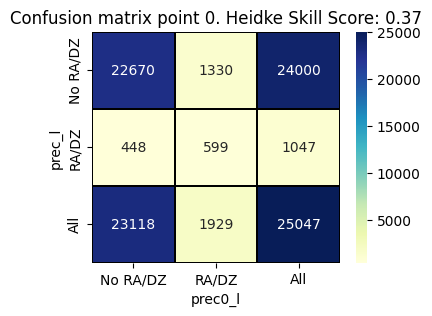

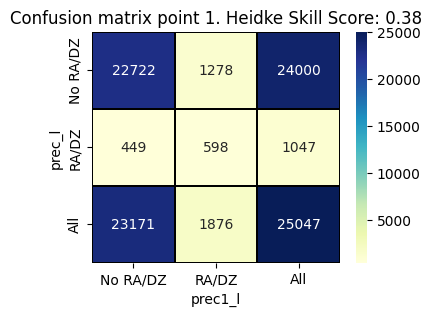

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 3760.624583311427
Reject H0,There is an association between meteorological model forecast and observed values


In [2]:
#@title Load station (visibility). Load meteorological model forecast D0. Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/LEBLY2018Y2022.csv",
                          usecols =["time","wxcodes_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Weather frequencies")
display(station["wxcodes_o"].value_counts(normalize=True).map(lambda n: '{:.2%}'.format(n)))

station["prec_l"] = "No RA/DZ"
mask = station['wxcodes_o'].str.contains("RA")
station.loc[mask,["prec_l"]] = "RA/DZ"
mask = station['wxcodes_o'].str.contains("DZ")
station.loc[mask,["prec_l"]] = "RA/DZ"
station["prec_l"]=pd.Categorical(station["prec_l"])

#display(station.sample(50).head(20))
print("*****************************")
print("Climatology RA or DZ")
display(station["prec_l"].value_counts(normalize=True).map(lambda n: '{:.0%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD0Y2020.csv",parse_dates=["time"])

model = pd.concat([mody2018,mody2019,mody2020]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
#display(df_all)


#label meteorological model variables prec0 and prec1
df_all["prec0_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec0]))
df_all["prec1_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec1]))

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.prec_l, df_all.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)


cm1 = pd.crosstab(df_all.prec_l, df_all.prec1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model forecast and observed values")
else:
    print("Retain H0,There is no association between meteorological model and observed values")


Round 0


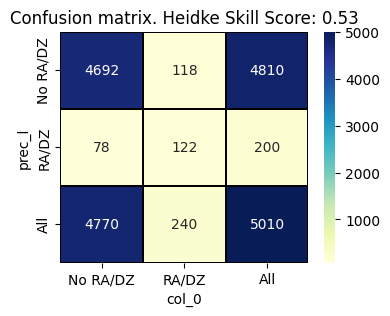

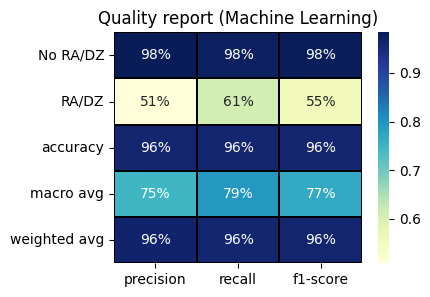

,feature,feature_per
52,dayofyear,3.7%
16,cin0,3.0%
41,cin1,3.0%
34,lhflx1,2.9%
25,dir1,2.9%
7,rh0,2.9%
50,hour,2.9%
42,cfh1,2.6%
43,cfl1,2.5%
8,visibility0,2.5%


Round 1


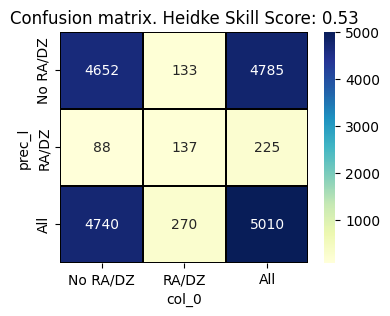

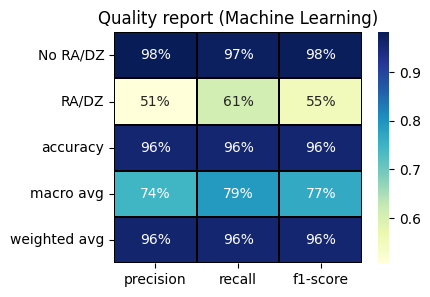

,feature,feature_per
52,dayofyear,3.2%
16,cin0,3.1%
25,dir1,2.9%
50,hour,2.9%
7,rh0,2.8%
19,cfm0,2.6%
39,shflx1,2.5%
43,cfl1,2.5%
8,visibility0,2.5%
34,lhflx1,2.5%


Round 2


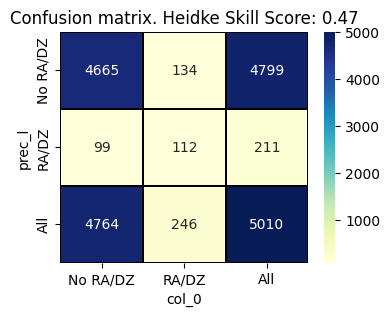

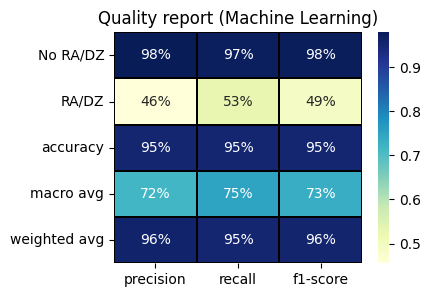

,feature,feature_per
52,dayofyear,3.3%
25,dir1,3.0%
41,cin1,2.9%
16,cin0,2.9%
50,hour,2.8%
7,rh0,2.7%
8,visibility0,2.7%
0,dir0,2.6%
34,lhflx1,2.5%
33,visibility1,2.5%


Round 3


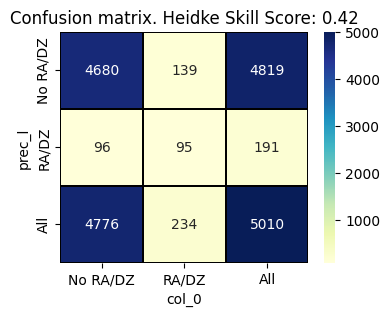

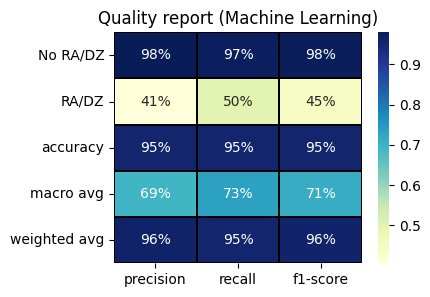

,feature,feature_per
50,hour,3.1%
52,dayofyear,3.1%
41,cin1,3.0%
39,shflx1,3.0%
16,cin0,3.0%
0,dir0,3.0%
8,visibility0,2.9%
32,rh1,2.6%
33,visibility1,2.5%
43,cfl1,2.5%


Round 4


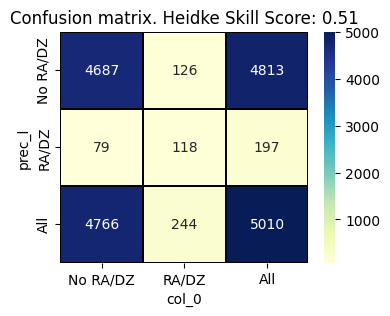

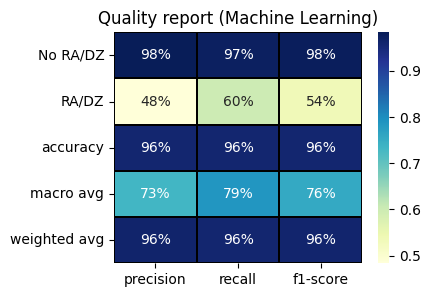

,feature,feature_per
34,lhflx1,3.1%
16,cin0,3.1%
52,dayofyear,3.0%
7,rh0,3.0%
50,hour,2.9%
25,dir1,2.8%
37,prec1,2.7%
41,cin1,2.7%
39,shflx1,2.7%
8,visibility0,2.7%


Round 5


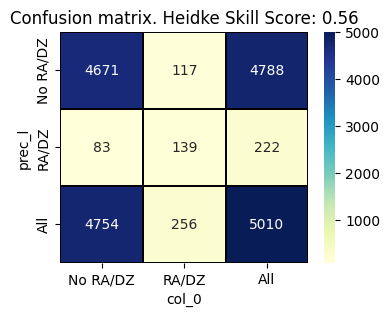

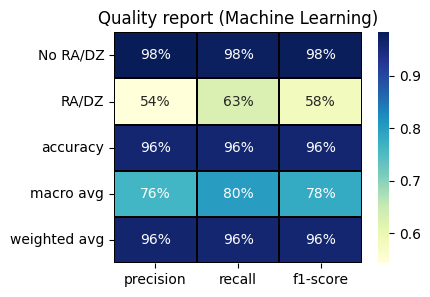

,feature,feature_per
52,dayofyear,3.5%
41,cin1,3.1%
50,hour,3.0%
0,dir0,3.0%
16,cin0,3.0%
7,rh0,3.0%
33,visibility1,2.8%
25,dir1,2.8%
34,lhflx1,2.6%
43,cfl1,2.5%


Round 6


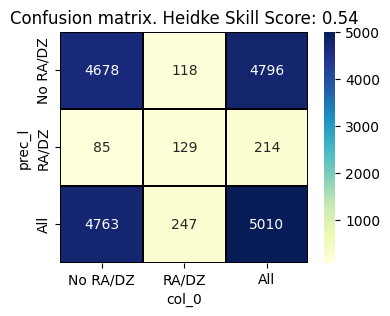

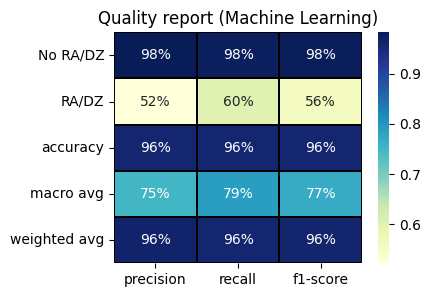

,feature,feature_per
52,dayofyear,3.6%
16,cin0,3.1%
50,hour,3.0%
25,dir1,2.9%
34,lhflx1,2.8%
0,dir0,2.8%
41,cin1,2.6%
8,visibility0,2.6%
32,rh1,2.6%
7,rh0,2.5%


Round 7


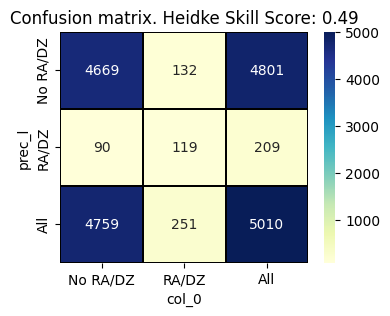

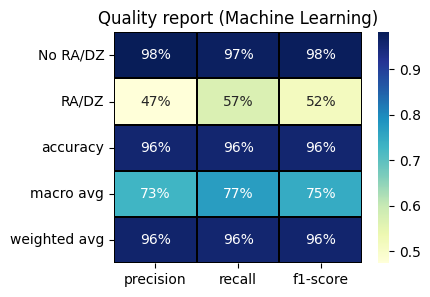

,feature,feature_per
16,cin0,3.3%
41,cin1,3.2%
52,dayofyear,3.0%
50,hour,2.9%
8,visibility0,2.8%
25,dir1,2.8%
39,shflx1,2.8%
34,lhflx1,2.8%
0,dir0,2.7%
17,cfh0,2.6%


Round 8


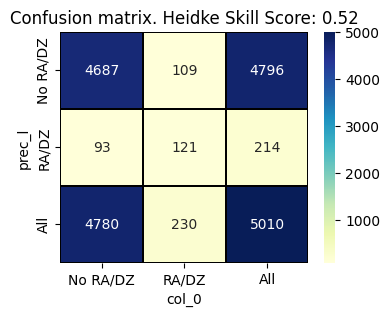

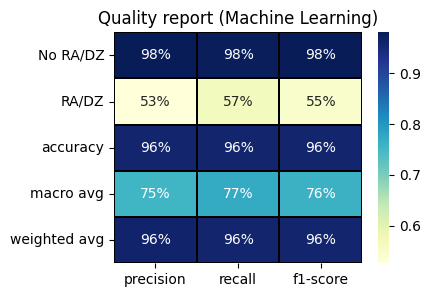

,feature,feature_per
52,dayofyear,3.5%
16,cin0,3.3%
7,rh0,3.3%
41,cin1,2.9%
39,shflx1,2.9%
33,visibility1,2.9%
50,hour,2.8%
34,lhflx1,2.8%
8,visibility0,2.7%
14,shflx0,2.5%


Round 9


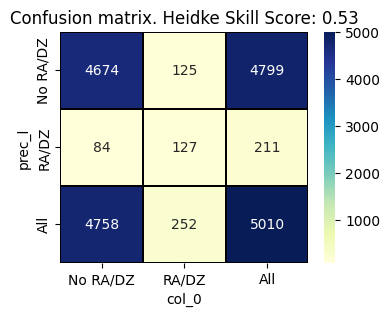

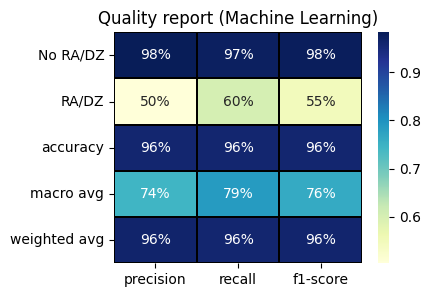

,feature,feature_per
16,cin0,3.3%
52,dayofyear,3.0%
41,cin1,2.9%
34,lhflx1,2.9%
25,dir1,2.8%
50,hour,2.8%
45,cft1,2.8%
33,visibility1,2.7%
0,dir0,2.7%
7,rh0,2.5%



HSS stadistics
             HSS
count  10.000000
mean    0.511210
std     0.040368
min     0.422829
25%     0.499279
50%     0.525443
75%     0.533331
max     0.560741
Shapiro test normality
p value: 0.1357050985097885
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 1.9095656913203334e-304
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1390.9871979351012
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 0.55 minutes


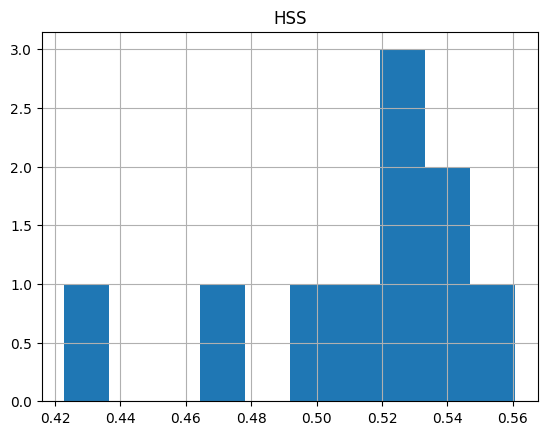

In [3]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [4]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/prec_LEBL_d0.al", 'wb'))

Round 0


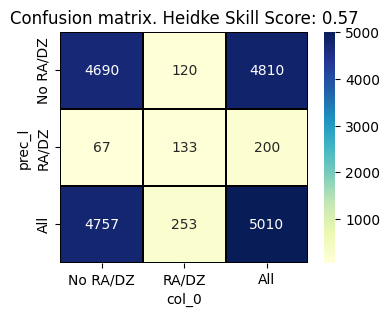

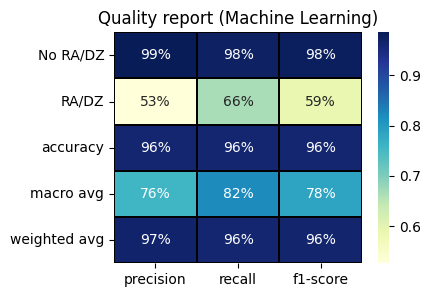

,feature,feature_per
44,cfm1,9.0%
18,cfl0,7.5%
43,cfl1,7.5%
19,cfm0,6.5%
45,cft1,6.2%
20,cft0,5.3%
10,lwflx0,3.0%
35,lwflx1,2.7%
37,prec1,2.3%
0,dir0,2.3%


Round 1


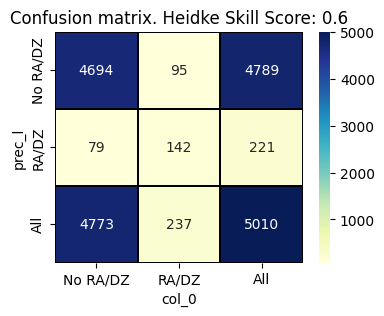

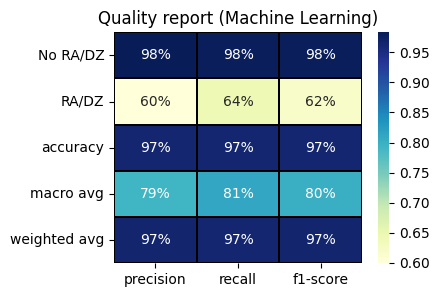

,feature,feature_per
44,cfm1,7.6%
19,cfm0,7.4%
20,cft0,7.4%
45,cft1,7.1%
18,cfl0,6.8%
43,cfl1,6.1%
10,lwflx0,3.0%
35,lwflx1,2.7%
37,prec1,2.1%
0,dir0,2.0%


Round 2


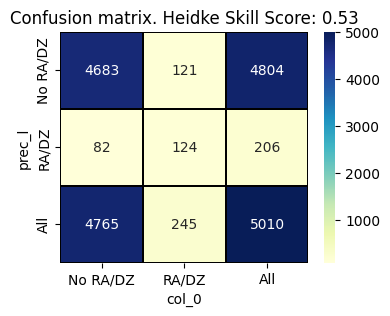

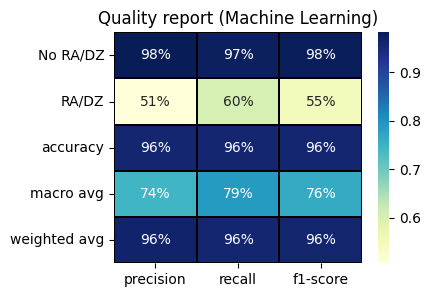

,feature,feature_per
45,cft1,7.7%
19,cfm0,7.6%
43,cfl1,7.2%
20,cft0,6.6%
44,cfm1,6.0%
18,cfl0,5.1%
10,lwflx0,3.2%
35,lwflx1,2.3%
25,dir1,2.3%
47,HGT8501,2.1%


Round 3


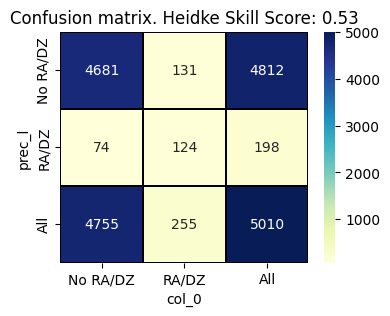

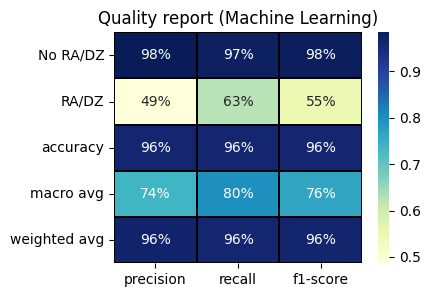

,feature,feature_per
44,cfm1,8.8%
19,cfm0,7.6%
45,cft1,7.5%
43,cfl1,6.9%
18,cfl0,6.1%
20,cft0,5.2%
10,lwflx0,3.3%
35,lwflx1,2.7%
0,dir0,2.1%
25,dir1,2.0%


Round 4


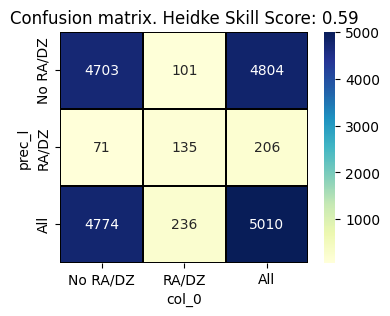

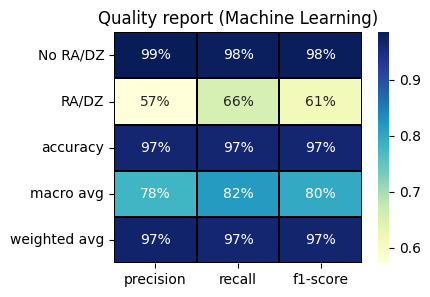

,feature,feature_per
19,cfm0,8.1%
18,cfl0,7.8%
43,cfl1,6.5%
44,cfm1,6.1%
45,cft1,6.0%
20,cft0,4.9%
10,lwflx0,3.7%
35,lwflx1,2.8%
0,dir0,2.7%
47,HGT8501,2.4%


Round 5


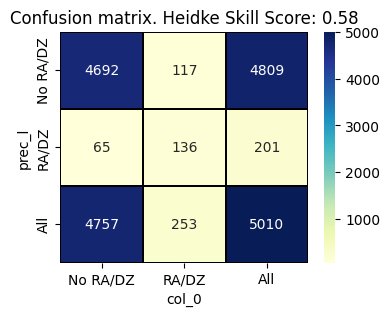

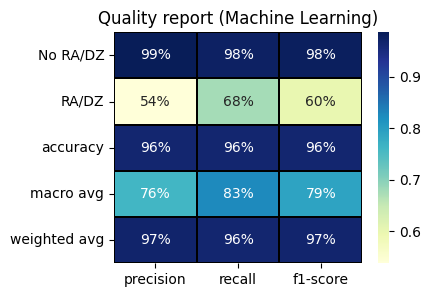

,feature,feature_per
19,cfm0,7.7%
45,cft1,7.1%
43,cfl1,6.9%
18,cfl0,6.4%
44,cfm1,6.4%
20,cft0,6.1%
35,lwflx1,3.4%
10,lwflx0,2.9%
0,dir0,2.1%
25,dir1,1.9%


Round 6


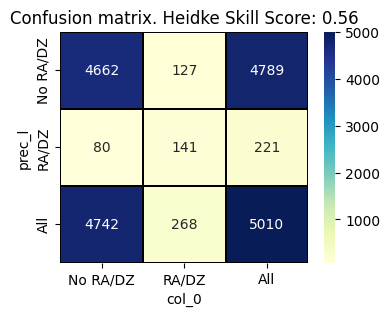

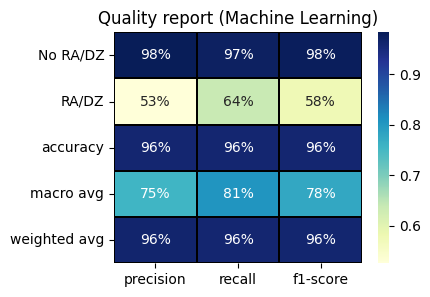

,feature,feature_per
19,cfm0,7.0%
43,cfl1,7.0%
20,cft0,6.9%
18,cfl0,6.8%
44,cfm1,6.0%
45,cft1,5.4%
35,lwflx1,3.1%
10,lwflx0,2.9%
22,HGT8500,2.2%
37,prec1,2.0%


Round 7


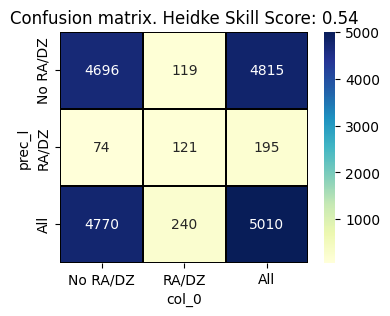

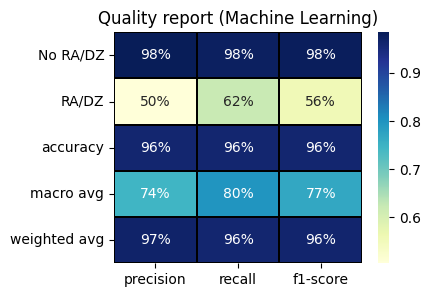

,feature,feature_per
44,cfm1,7.8%
19,cfm0,7.1%
18,cfl0,6.5%
20,cft0,6.1%
43,cfl1,5.8%
45,cft1,5.2%
10,lwflx0,3.0%
35,lwflx1,2.8%
22,HGT8500,2.5%
25,dir1,2.2%


Round 8


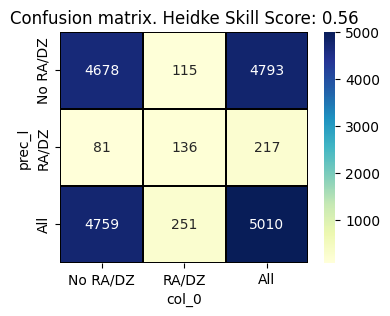

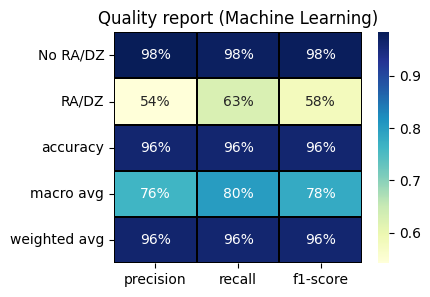

,feature,feature_per
44,cfm1,9.7%
18,cfl0,8.6%
19,cfm0,7.4%
43,cfl1,6.8%
45,cft1,5.6%
20,cft0,3.9%
10,lwflx0,2.9%
35,lwflx1,2.6%
37,prec1,2.2%
47,HGT8501,2.2%


Round 9


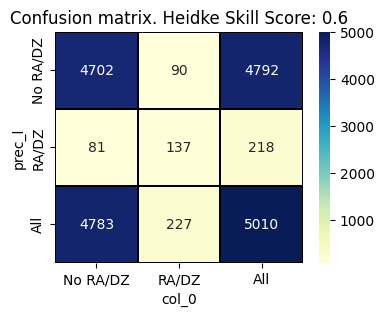

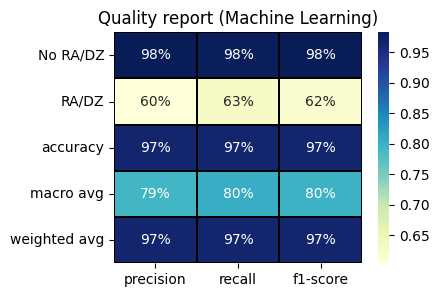

,feature,feature_per
45,cft1,7.7%
44,cfm1,7.0%
18,cfl0,6.9%
43,cfl1,6.9%
19,cfm0,6.9%
20,cft0,5.2%
10,lwflx0,3.0%
35,lwflx1,2.9%
25,dir1,2.1%
37,prec1,2.0%



HSS stadistics
             HSS
count  10.000000
mean    0.564868
std     0.028286
min     0.526389
25%     0.541103
50%     0.564361
75%     0.589830
max     0.601914
Shapiro test normality
p value: 0.38665592670440674
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1777.6071187151656
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 0.94 minutes


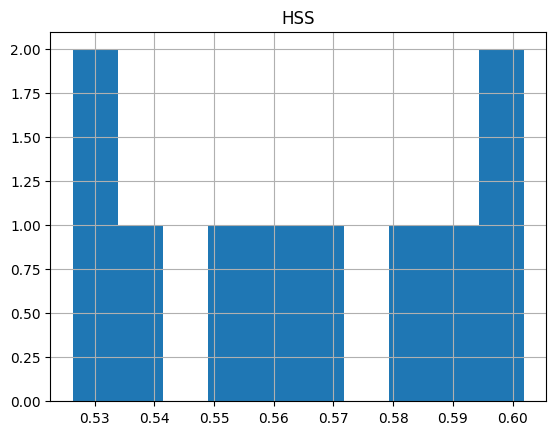

In [5]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")







In [6]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/prec_LEBL_d0.al", 'wb'))

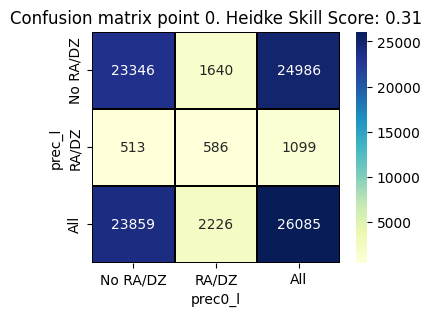

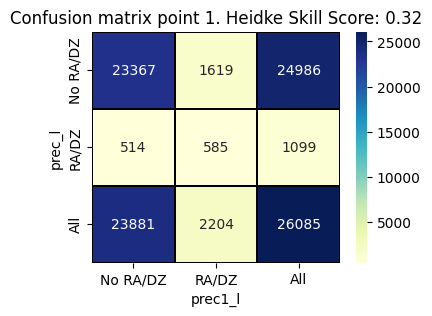

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 2942.5790237954
Reject H0,There is an association between meteorological model forecast and observed values


In [7]:
#@title Load meteorological model forecast D1.Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEBL/input_files/lat41.296lon2.078p2R12KmD1Y2020.csv",parse_dates=["time"])

model = pd.concat([mody2018,mody2019,mody2020]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
#display(df_all)


#label meteorological model variables prec0 and prec1
df_all["prec0_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec0]))
df_all["prec1_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec1]))

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.prec_l, df_all.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)


cm1 = pd.crosstab(df_all.prec_l, df_all.prec1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model forecast and observed values")
else:
    print("Retain H0,There is no association between meteorological model and observed values")


Round 0


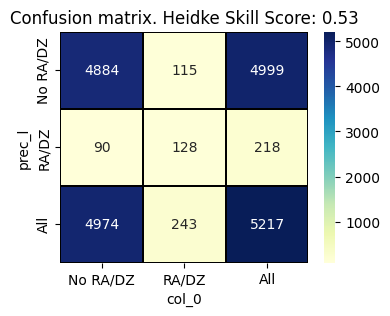

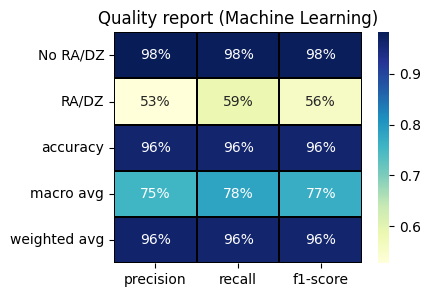

,feature,feature_per
52,dayofyear,4.0%
50,hour,3.3%
41,cin1,3.3%
33,visibility1,2.8%
8,visibility0,2.8%
16,cin0,2.7%
17,cfh0,2.6%
32,rh1,2.6%
39,shflx1,2.5%
44,cfm1,2.4%


Round 1


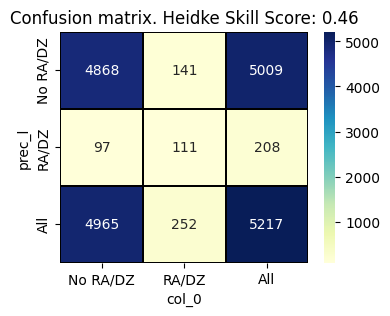

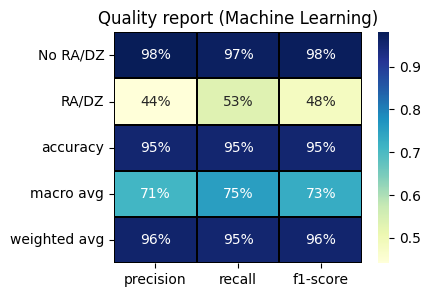

,feature,feature_per
52,dayofyear,4.0%
17,cfh0,3.7%
41,cin1,3.5%
32,rh1,2.8%
50,hour,2.7%
16,cin0,2.7%
0,dir0,2.6%
15,cape0,2.6%
34,lhflx1,2.6%
33,visibility1,2.5%


Round 2


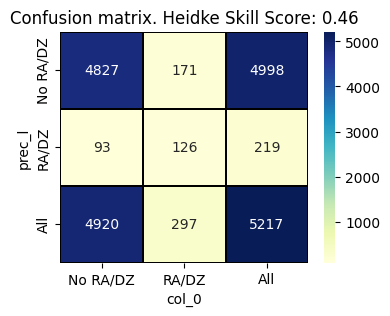

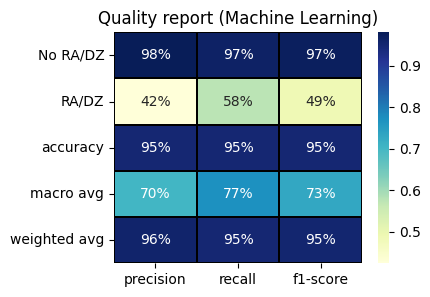

,feature,feature_per
52,dayofyear,3.8%
50,hour,3.4%
17,cfh0,3.2%
41,cin1,3.2%
16,cin0,2.8%
32,rh1,2.7%
42,cfh1,2.6%
9,lhflx0,2.6%
8,visibility0,2.5%
0,dir0,2.5%


Round 3


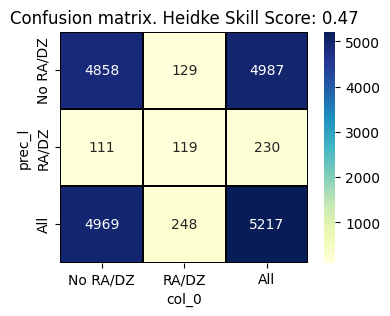

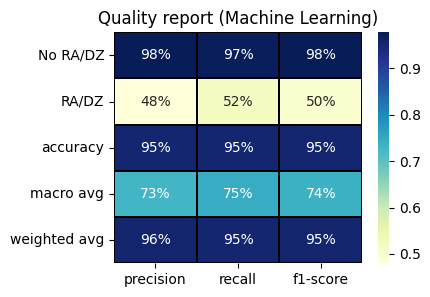

,feature,feature_per
42,cfh1,3.5%
52,dayofyear,3.5%
50,hour,3.1%
44,cfm1,3.0%
16,cin0,2.9%
41,cin1,2.9%
25,dir1,2.8%
9,lhflx0,2.6%
0,dir0,2.5%
34,lhflx1,2.5%


Round 4


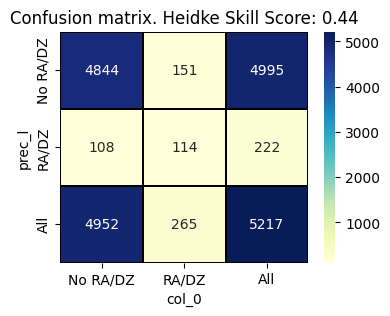

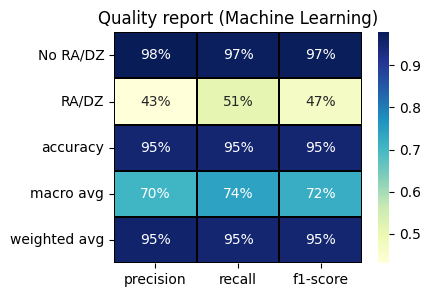

,feature,feature_per
52,dayofyear,3.8%
32,rh1,3.2%
50,hour,3.2%
41,cin1,3.1%
33,visibility1,2.9%
16,cin0,2.6%
9,lhflx0,2.6%
8,visibility0,2.6%
0,dir0,2.5%
40,cape1,2.5%


Round 5


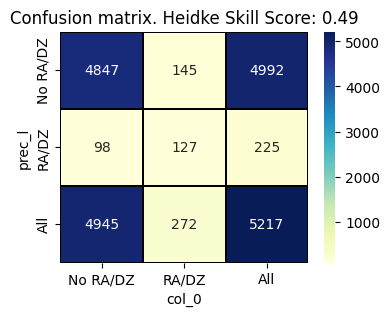

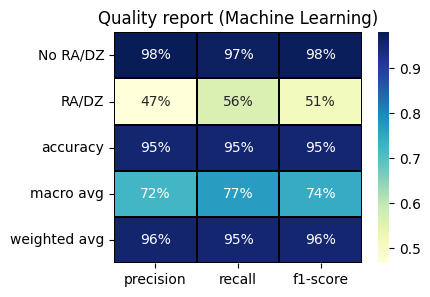

,feature,feature_per
50,hour,3.4%
52,dayofyear,3.4%
41,cin1,3.2%
8,visibility0,3.1%
34,lhflx1,2.7%
32,rh1,2.7%
40,cape1,2.6%
25,dir1,2.6%
17,cfh0,2.6%
0,dir0,2.5%


Round 6


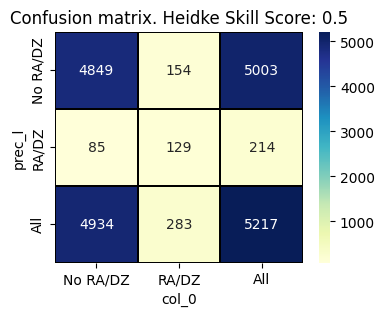

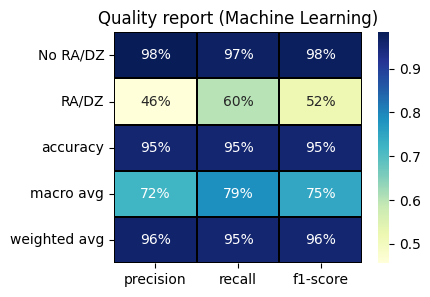

,feature,feature_per
52,dayofyear,3.5%
41,cin1,3.4%
50,hour,3.0%
32,rh1,2.9%
33,visibility1,2.9%
17,cfh0,2.7%
40,cape1,2.7%
0,dir0,2.6%
16,cin0,2.6%
8,visibility0,2.5%


Round 7


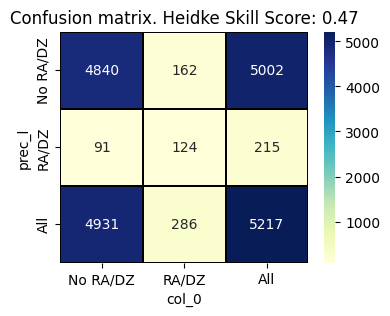

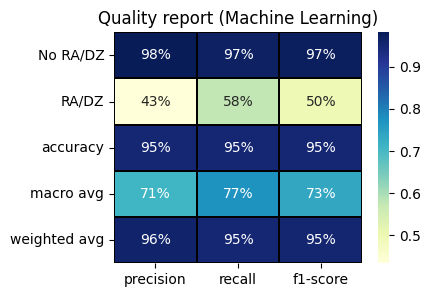

,feature,feature_per
52,dayofyear,4.0%
41,cin1,3.5%
17,cfh0,3.1%
8,visibility0,3.0%
50,hour,3.0%
25,dir1,2.7%
0,dir0,2.6%
16,cin0,2.5%
5,mslp0,2.5%
34,lhflx1,2.5%


Round 8


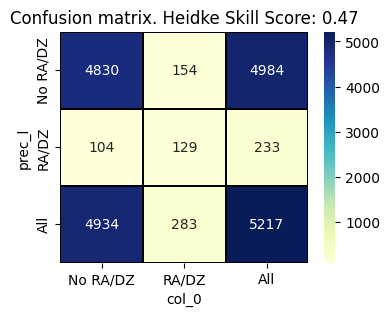

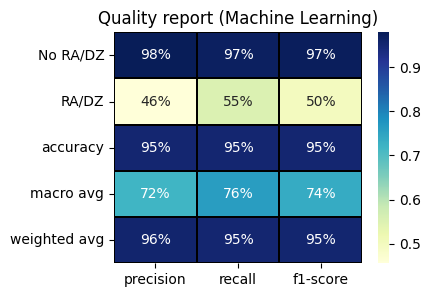

,feature,feature_per
52,dayofyear,3.9%
41,cin1,3.1%
50,hour,2.9%
16,cin0,2.8%
33,visibility1,2.8%
8,visibility0,2.8%
9,lhflx0,2.7%
0,dir0,2.7%
40,cape1,2.7%
34,lhflx1,2.6%


Round 9


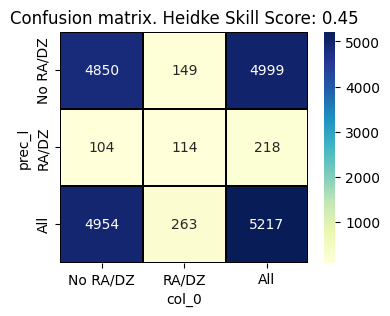

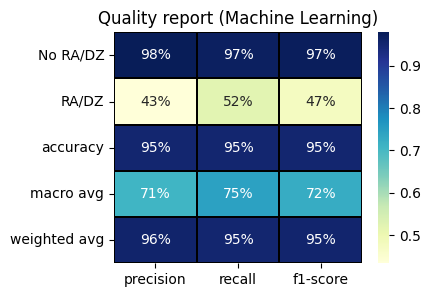

,feature,feature_per
41,cin1,3.5%
52,dayofyear,3.4%
17,cfh0,3.2%
8,visibility0,3.0%
0,dir0,2.9%
16,cin0,2.9%
33,visibility1,2.9%
50,hour,2.8%
44,cfm1,2.7%
39,shflx1,2.6%



HSS stadistics
             HSS
count  10.000000
mean    0.474791
std     0.026529
min     0.442347
25%     0.459829
50%     0.471957
75%     0.483692
max     0.534822
Shapiro test normality
p value: 0.2950601279735565
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 1.582567174345247e-230
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1050.8602003848791
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 0.69 minutes


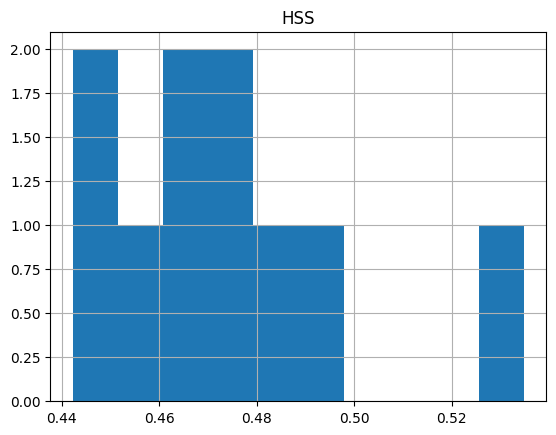

In [8]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score
start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [9]:
#@title Save last algorithm round 9

x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/prec_LEBL_d1.al", 'wb'))


Round 0


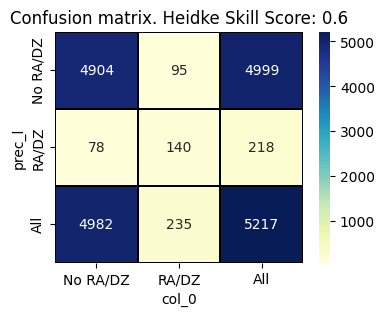

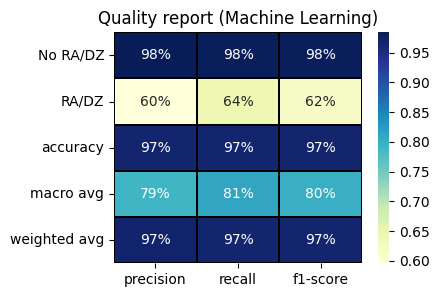

,feature,feature_per
44,cfm1,6.9%
19,cfm0,6.5%
18,cfl0,5.2%
43,cfl1,5.1%
45,cft1,4.3%
20,cft0,3.8%
47,HGT8501,3.0%
46,HGT5001,2.8%
22,HGT8500,2.8%
0,dir0,2.5%


Round 1


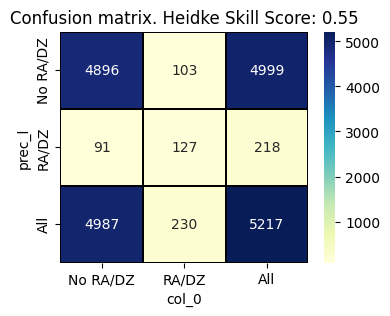

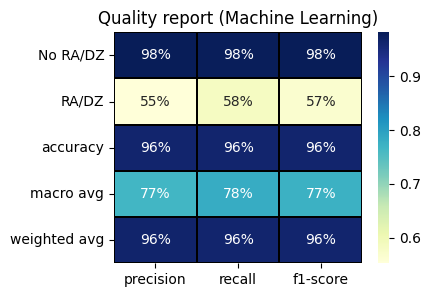

,feature,feature_per
44,cfm1,7.3%
19,cfm0,5.9%
43,cfl1,5.4%
18,cfl0,5.0%
45,cft1,4.5%
20,cft0,4.3%
21,HGT5000,2.7%
22,HGT8500,2.7%
47,HGT8501,2.5%
0,dir0,2.4%


Round 2


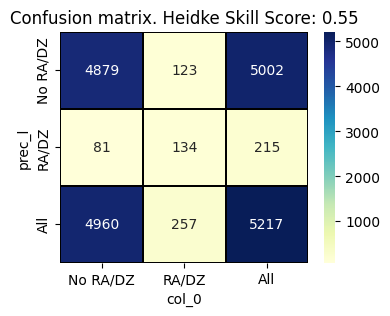

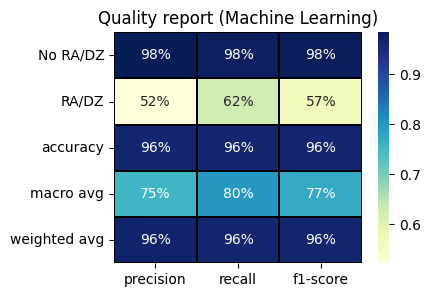

,feature,feature_per
18,cfl0,5.7%
19,cfm0,5.6%
44,cfm1,5.3%
20,cft0,4.8%
45,cft1,4.7%
43,cfl1,4.5%
46,HGT5001,3.1%
30,mslp1,2.8%
22,HGT8500,2.8%
47,HGT8501,2.7%


Round 3


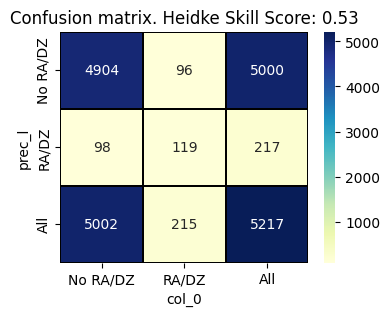

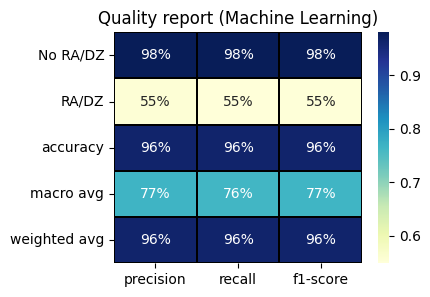

,feature,feature_per
45,cft1,6.7%
19,cfm0,6.3%
20,cft0,5.8%
18,cfl0,5.7%
43,cfl1,5.1%
44,cfm1,5.0%
22,HGT8500,2.6%
0,dir0,2.5%
5,mslp0,2.4%
46,HGT5001,2.4%


Round 4


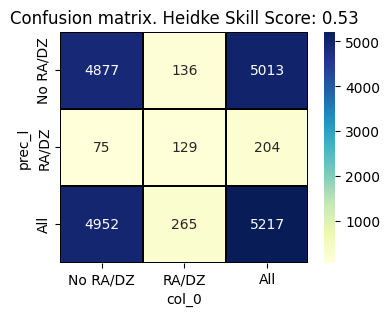

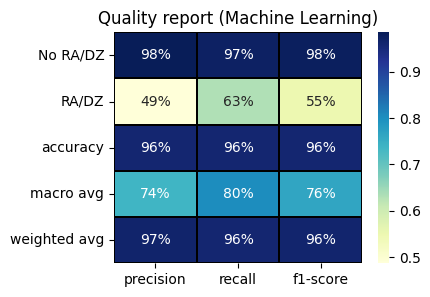

,feature,feature_per
43,cfl1,6.5%
19,cfm0,5.7%
44,cfm1,5.5%
45,cft1,4.8%
18,cfl0,4.8%
20,cft0,4.3%
46,HGT5001,2.9%
47,HGT8501,2.5%
21,HGT5000,2.5%
22,HGT8500,2.4%


Round 5


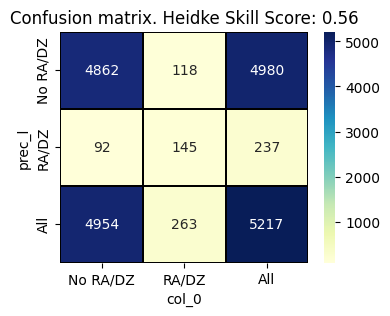

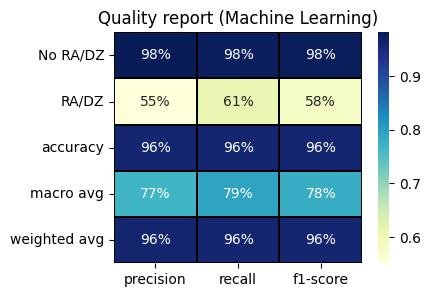

,feature,feature_per
44,cfm1,7.3%
19,cfm0,6.4%
43,cfl1,5.3%
18,cfl0,4.9%
20,cft0,4.3%
45,cft1,4.3%
47,HGT8501,2.7%
22,HGT8500,2.7%
21,HGT5000,2.5%
0,dir0,2.3%


Round 6


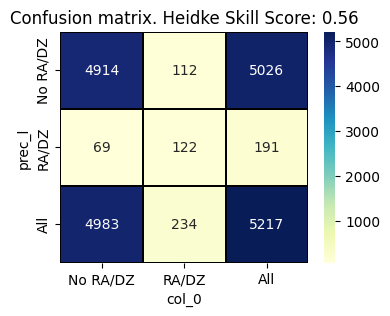

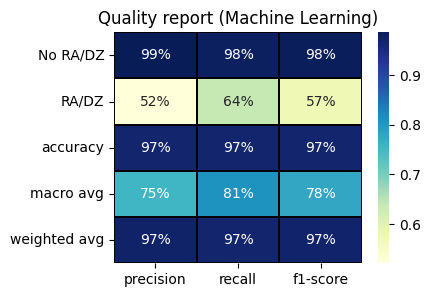

,feature,feature_per
19,cfm0,6.2%
45,cft1,6.1%
18,cfl0,5.9%
43,cfl1,5.6%
44,cfm1,5.1%
20,cft0,3.8%
21,HGT5000,2.5%
30,mslp1,2.5%
46,HGT5001,2.5%
22,HGT8500,2.4%


Round 7


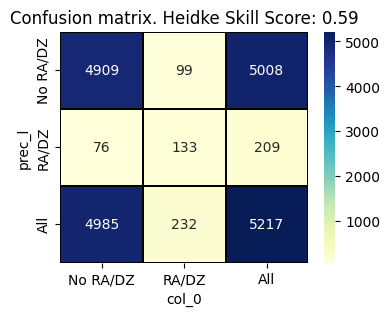

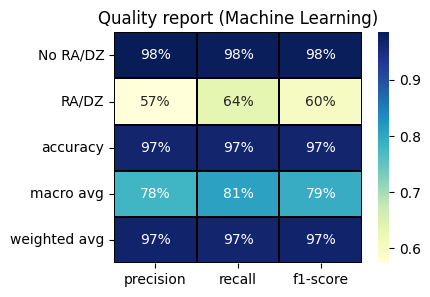

,feature,feature_per
19,cfm0,6.6%
45,cft1,6.5%
20,cft0,6.0%
44,cfm1,5.3%
18,cfl0,5.1%
43,cfl1,4.8%
46,HGT5001,2.7%
30,mslp1,2.4%
22,HGT8500,2.3%
10,lwflx0,2.2%


Round 8


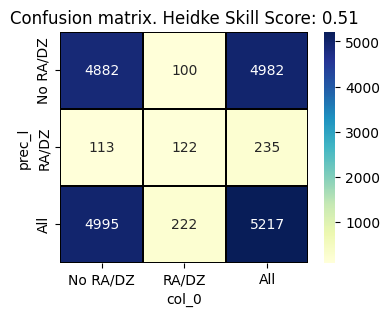

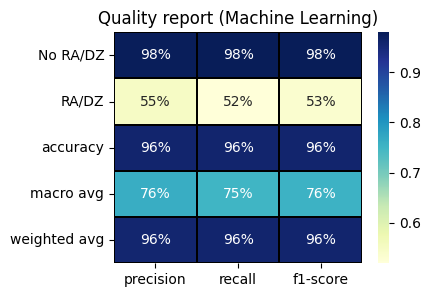

,feature,feature_per
44,cfm1,6.8%
45,cft1,6.4%
43,cfl1,5.7%
19,cfm0,5.7%
18,cfl0,5.0%
20,cft0,4.5%
47,HGT8501,2.8%
22,HGT8500,2.5%
46,HGT5001,2.4%
25,dir1,2.3%


Round 9


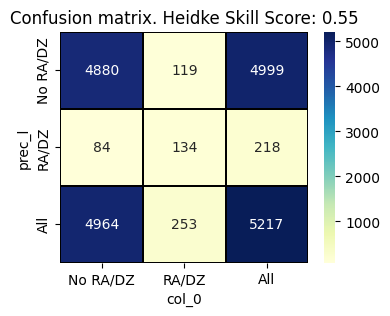

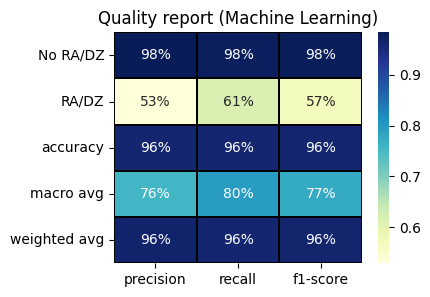

,feature,feature_per
18,cfl0,7.7%
44,cfm1,6.8%
43,cfl1,6.3%
19,cfm0,5.7%
45,cft1,5.7%
20,cft0,3.4%
46,HGT5001,3.1%
47,HGT8501,2.8%
22,HGT8500,2.4%
30,mslp1,2.3%



HSS stadistics
             HSS
count  10.000000
mean    0.551886
std     0.026079
min     0.512586
25%     0.535520
50%     0.548148
75%     0.558247
max     0.600794
Shapiro test normality
p value: 0.6382042765617371
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1567.7340299531302
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 0.96 minutes


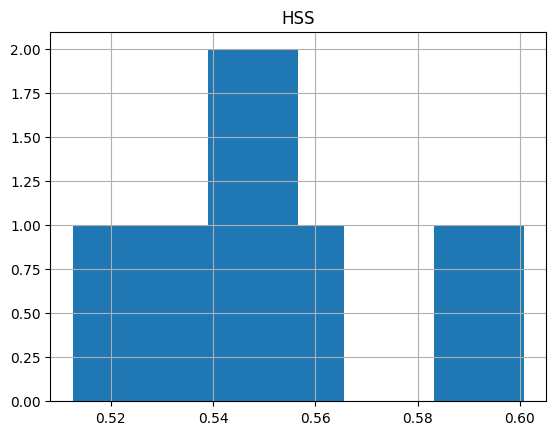

In [10]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEBL/algorithms/prec_LEBL_d1.al", 'wb'))